<a href="https://colab.research.google.com/github/76187-DHBW/76187/blob/main/76187.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1 - Total Energy: 470.06 kWh
Task 2 - Average pump efficiency: 71.67 %
Task 3 - Unused Energy: 133.17 kWh
Task 4 - Plotting the Results:


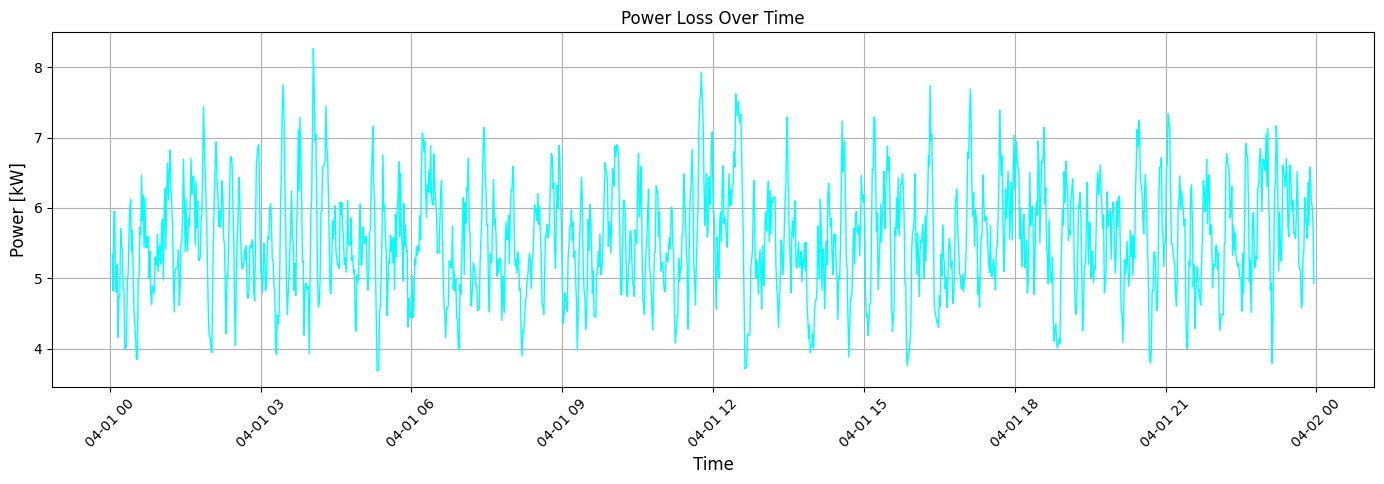

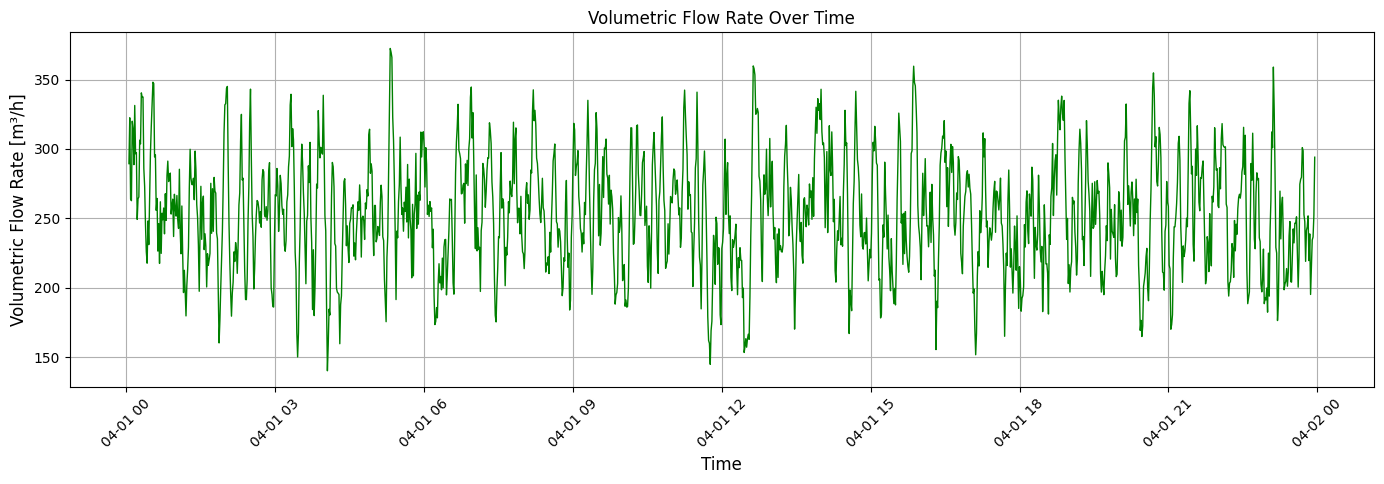

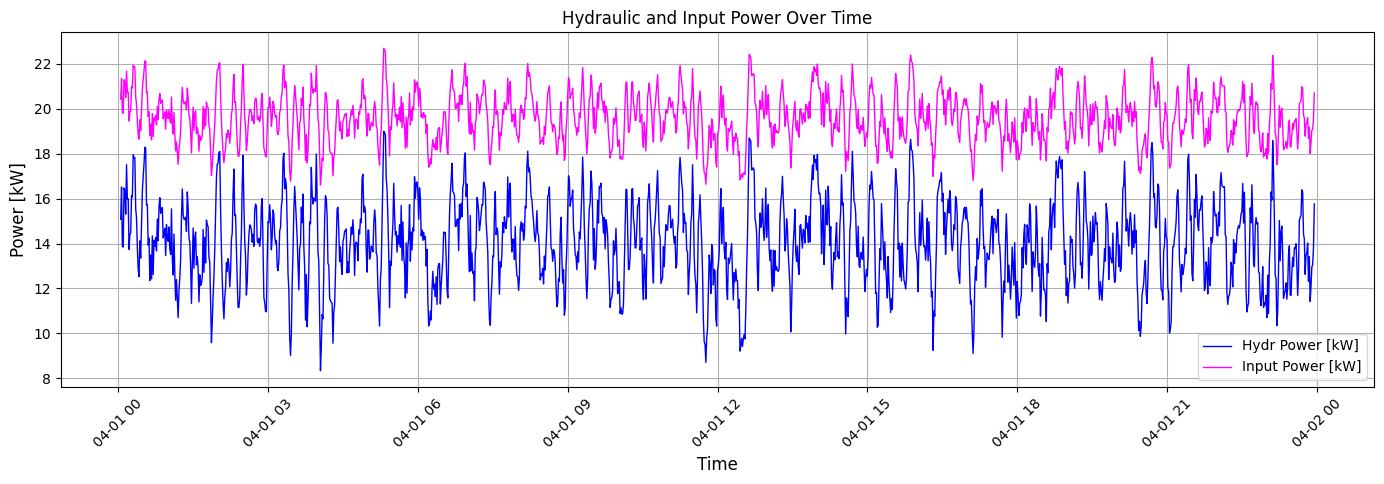

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# The CSV file is loaded with a header.
# The volumetric flow rate per hour is then converted to flow rate per second.

url = 'https://raw.githubusercontent.com/76187-DHBW/76187/refs/heads/main/volume_flow_data.csv'
data_vol_flow = pd.read_csv(url, sep=',')
data_vol_flow.columns = ['timestamp', 'flow_rate_m3h']
data_vol_flow['timestamp'] = pd.to_datetime(data_vol_flow['timestamp'], format='%Y-%m-%d %H:%M:%S')
data_vol_flow['flow_rate_m3s'] = data_vol_flow['flow_rate_m3h'] / 3600
data_vol_flow['time_delta_s'] = data_vol_flow['timestamp'].diff().dt.total_seconds()
data_vol_flow = data_vol_flow.dropna().reset_index(drop=True)


# A pump characteristic curve is created by interpolating the given values
# and the required constants are defined
# Density of the fluid (rho)
# Gravitational acceleration (g)

flow_m3h = np.array([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])
head_m = np.array([23.5, 23.5, 23.25, 22.75, 22.5, 21.9, 21, 20, 18.5, 17.5, 16, 14.5])
head_interpolator = interp1d(flow_m3h, head_m, bounds_error=False, fill_value="extrapolate")
data_vol_flow['head_m'] = head_interpolator(data_vol_flow['flow_rate_m3h'])
rho = 969   # kg/m³
g = 9.81    # m/s²


# Task 1: Calculation of Energy Consumption
# The rated power is taken from the attached datasheet

data_vol_flow['P_hydr_W'] = rho * g * data_vol_flow['flow_rate_m3s'] * data_vol_flow['head_m']            # W
flow = np.array([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])                              # m³/h
height = np.array([12.25, 13.75, 15.5, 16.75, 18, 19.75, 21, 22.21, 23.25, 24, 24.5, 25.5])             # kW
input_p_int = interp1d(flow, height, bounds_error=False, fill_value="extrapolate")
data_vol_flow['P_input_W'] = input_p_int(data_vol_flow['flow_rate_m3h']) * 1000                           # W
data_vol_flow['E_input'] = data_vol_flow['P_input_W'] * data_vol_flow['time_delta_s']
E_total_in = data_vol_flow['E_input'].sum() / 3.6e6

print(f"Task 1 - Total Energy: {E_total_in:.2f} kWh")


# Task 2: Calculation of the average efficiency

data_vol_flow['E_hydr'] = data_vol_flow['P_hydr_W'] * data_vol_flow['time_delta_s']
E_total_hydr = data_vol_flow['E_hydr'].sum() / 3.6e6
pump_eff = (E_total_hydr / E_total_in) * 100
print(f"Task 2 - Average pump efficiency: {pump_eff:.2f} %")


# Task 3: Calculation of Power Losses

E_unused = E_total_in - E_total_hydr
print(f"Task 3 - Unused Energy: {E_unused:.2f} kWh")


# Task 4: Plotting the Results

print(f"Task 4 - Plotting the Results:")
data_vol_flow['P_input_kW'] = data_vol_flow['P_input_W'] / 1000
data_vol_flow['P_hydr_kW'] = data_vol_flow['P_hydr_W'] / 1000
data_vol_flow['P_loss_kW'] = data_vol_flow['P_input_kW'] - data_vol_flow['P_hydr_kW']
data_vol_flow_smoothed = data_vol_flow[['timestamp', 'flow_rate_m3h', 'P_hydr_kW', 'P_input_kW', 'P_loss_kW']].copy()
data_vol_flow_smoothed[['flow_rate_m3h', 'P_hydr_kW', 'P_input_kW', 'P_loss_kW']] = data_vol_flow_smoothed[['flow_rate_m3h', 'P_hydr_kW', 'P_input_kW', 'P_loss_kW']].rolling(window=5, center=True).mean()


plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16})

# Diagramm 3: Power Loss Over Time
plt.figure(figsize=(14, 5))
plt.plot(data_vol_flow_smoothed['timestamp'], data_vol_flow_smoothed['P_loss_kW'], color='cyan', linewidth=1)
plt.title('Power Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Power [kW]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 1: Volumetric Flow Rate Over Time
plt.figure(figsize=(14, 5))
plt.plot(data_vol_flow_smoothed['timestamp'], data_vol_flow_smoothed['flow_rate_m3h'], color='green', linewidth=1)
plt.title('Volumetric Flow Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Volumetric Flow Rate [m³/h]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Hydraulic Power vs. Input Power
plt.figure(figsize=(14, 5))
plt.plot(data_vol_flow_smoothed['timestamp'], data_vol_flow_smoothed['P_hydr_kW'], label='Hydr Power [kW]', color='blue', linewidth=1)
plt.plot(data_vol_flow_smoothed['timestamp'], data_vol_flow_smoothed['P_input_kW'], label='Input Power [kW]', color='magenta', linewidth=1)
plt.title('Hydraulic and Input Power Over Time')
plt.xlabel('Time')
plt.ylabel('Power [kW]')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


